In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import truncnorm
import seaborn as sns
import warnings
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment
import os

In [3]:
# Setup
warnings.filterwarnings('ignore')
np.random.seed(42)  # For reproducibility
plt.style.use('default')
sns.set_palette("husl")

In [4]:
print("✅ All libraries imported successfully!")
print("🎯 Monte Carlo Health Risk Assessment Ready")

✅ All libraries imported successfully!
🎯 Monte Carlo Health Risk Assessment Ready


In [5]:
# Parameters
PARAMETERS = {
    'FIR_fuchka': 0.1,      # kg/day (variable)
    'FIR_tamarind': 0.03,   # L/day (variable) 
    'BW_child': 24,         # kg (variable)
    'BW_adult': 70,         # kg (variable)
    'ED': 56,               # years (Fixed)
    'EFr': 365,             # days/year (Fixed)
    'ATn': 20440            # days (56×365) (Fixed)
}

In [6]:
RFD_VALUES = {
    'Pb': 1.4,
    'Cd': 0.5, 
    'Cr': 3,
    'Mn': 24,
    'Fe': 700,
    'Ni': 20,
    'Cu': 40,
    'Zn': 300,
    'As': 0.3,
    'Hg': 0.3,
    'Al': 7000
}

In [7]:
# Distribution parameters
DISTRIBUTIONS = {
    'Metal_C_All': 'Lognormal',
    'BW_Adult': 'Truncated Normal (45-100 kg)',
    'BW_Child': 'Truncated Normal (20-50 kg)', 
    'IR_Fuchka': 'Triangular',
    'IR_Tamarind': 'Triangular'
}

In [8]:
# Monte Carlo parameters
N_ITERATIONS = 1000
N_SAMPLES = 42

In [9]:
print("📋 Parameters loaded:")
for key, value in PARAMETERS.items():
    print(f"  {key}: {value}")

print(f"\n🧪 RfD Values loaded for {len(RFD_VALUES)} metals")
print(f"📊 Distribution types defined for {len(DISTRIBUTIONS)} parameters")
print(f"🔄 Monte Carlo setup: {N_ITERATIONS} iterations, {N_SAMPLES} samples")


📋 Parameters loaded:
  FIR_fuchka: 0.1
  FIR_tamarind: 0.03
  BW_child: 24
  BW_adult: 70
  ED: 56
  EFr: 365
  ATn: 20440

🧪 RfD Values loaded for 11 metals
📊 Distribution types defined for 5 parameters
🔄 Monte Carlo setup: 1000 iterations, 42 samples


In [10]:
fuchka_df=pd.read_excel('MonteCarlo_Inputs_HealthRisk.xlsx',sheet_name='Concentration_Data_Fuchka')
fuchka_df.head()

,Sample ID,Pb,Cd,Cr,Hg,Co,Ni,Al,Fe,Cu,Zn,Mn
0,1,1790.62,48.04,141.16,0.550,53.86,462.26,21126.69,18971.68,1400.48,4391.82,6275.88
1,2,86.32,1.00,10.00,4.710,10.00,10.00,4269.81,17148.46,1266.94,5395.86,6087.30
2,3,1190.14,29.58,101.52,4.344,47.18,317.98,8444.97,63266.96,1386.72,5232.78,5352.08
3,4,10.00,1.00,142.34,0.550,60.34,233.06,6107.98,11899.68,1354.14,6348.70,7407.26
4,5,10.00,1.00,116.78,0.550,57.06,261.96,3461.49,9796.88,1222.76,4742.80,5631.78


In [11]:
tamarind_df=pd.read_excel('MonteCarlo_Inputs_HealthRisk.xlsx',sheet_name='Concentration_Data_Tamarind')
tamarind_df.head()

,Sample ID,Pb,Cd,Cr,Hg,Co,Ni,Al,Fe,Cu,Zn,Mn
0,1,1.2500,2.0475,18.86625,0.37500,4.1675,21.9550,2849.26625,9219.2975,342.6425,408.7250,2189.7475
1,2,1.2500,13.3380,37.70625,0.37500,1.2500,1.2500,2244.35750,8062.3800,339.0900,250.0525,1097.1975
2,3,1.2500,1.8720,68.57625,0.37500,5.5950,20.0025,5647.76750,11449.1825,466.3300,558.1450,1569.5975
3,4,1.2500,6.4350,14.78875,0.37500,1.2500,5.6875,4057.42875,11744.1975,222.1325,446.5475,1237.5225
4,5,2689.8975,7.8000,24.04875,1.01275,3.0250,52.7925,2235.84000,2770.1975,150.3725,883.5125,407.4475


In [12]:
print(f"📊 Fuchka dataset: {fuchka_df.shape} (samples × metals)")
print(f"📊 Tamarind dataset: {tamarind_df.shape} (samples × metals)")

📊 Fuchka dataset: (42, 12) (samples × metals)
📊 Tamarind dataset: (42, 12) (samples × metals)


In [13]:
def sample_body_weight(age_group, n_samples=N_ITERATIONS):
    """
    Sample body weight using truncated normal distribution
    """
    if age_group == 'adult':
        # Truncated Normal (45-100 kg) - mean=70, std=12
        mean, std = PARAMETERS['BW_adult'], 12
        a, b = (45 - mean) / std, (100 - mean) / std
        return truncnorm.rvs(a, b, loc=mean, scale=std, size=n_samples)
    else:  # child
        # Truncated Normal (20-50 kg) - mean=24, std=6  
        mean, std = PARAMETERS['BW_child'], 6
        a, b = (20 - mean) / std, (50 - mean) / std
        return truncnorm.rvs(a, b, loc=mean, scale=std, size=n_samples)


In [14]:
def sample_ingestion_rate(food_type, n_samples=N_ITERATIONS):
    """
    Sample ingestion rate using triangular distribution
    """
    if food_type == 'fuchka':
        # Triangular distribution around 0.1 kg/day
        base_val = PARAMETERS['FIR_fuchka']
        # min, mode, max for triangular
        min_val, mode_val, max_val = base_val * 0.5, base_val, base_val * 1.5
        return np.random.triangular(min_val, mode_val, max_val, n_samples)
    else:  # tamarind
        # Triangular distribution around 0.03 L/day
        base_val = PARAMETERS['FIR_tamarind'] 
        min_val, mode_val, max_val = base_val * 0.3, base_val, base_val * 2.0
        return np.random.triangular(min_val, mode_val, max_val, n_samples)


In [15]:
def sample_metal_concentration(concentration, n_samples=N_ITERATIONS):
    """
    Sample metal concentration using lognormal distribution
    """
    # Lognormal distribution with mean=concentration, cv=0.3
    mu = np.log(concentration)
    sigma = 0.3  # Coefficient of variation
    samples = np.random.lognormal(mu, sigma, n_samples)
    # Ensure positive values and reasonable bounds
    return np.clip(samples, concentration * 0.1, concentration * 5.0)

In [16]:
print("✅ Distribution sampling functions defined:")
print("  - Body Weight: Truncated Normal (Adult: 45-100kg, Child: 20-50kg)")
print("  - Ingestion Rate: Triangular (Fuchka: 0.05-0.15kg/day, Tamarind: 0.009-0.06L/day)")
print("  - Metal Concentration: Lognormal (CV=0.3)")

✅ Distribution sampling functions defined:
  - Body Weight: Truncated Normal (Adult: 45-100kg, Child: 20-50kg)
  - Ingestion Rate: Triangular (Fuchka: 0.05-0.15kg/day, Tamarind: 0.009-0.06L/day)
  - Metal Concentration: Lognormal (CV=0.3)


In [17]:
# Test sampling functions
print(f"\n🧪 Sample test:")
test_bw_adult = sample_body_weight('adult', 10)
test_ir_fuchka = sample_ingestion_rate('fuchka', 10)
print(f"Adult BW sample (n=10): {test_bw_adult.round(2)}")
print(f"Fuchka IR sample (n=10): {test_ir_fuchka.round(4)}")


🧪 Sample test:
Adult BW sample (n=10): [66.46 89.26 77.44 73.12 58.59 58.58 52.75 83.14 73.19 76.61]
Fuchka IR sample (n=10): [0.0601 0.1377 0.1211 0.0826 0.0802 0.0803 0.089  0.1013 0.0965 0.0882]


In [18]:
def calculate_thq_monte_carlo(concentration, metal, fir_samples, bw_samples):
    """
    Calculate THQ using Monte Carlo simulation
    Formula: THQ = (EFr × ED × FIR × C) / (RfD × BW × ATn)
    """
    # Get RfD for the metal
    rfd = RFD_VALUES[metal]
    
    # Sample metal concentration
    conc_samples = sample_metal_concentration(concentration, N_ITERATIONS)
    
    # Fixed parameters
    efr = PARAMETERS['EFr']
    ed = PARAMETERS['ED']  
    atn = PARAMETERS['ATn']
    
    # Calculate THQ for each iteration
    numerator = efr * ed * fir_samples * conc_samples
    denominator = rfd * bw_samples * atn
    
    thq_values = numerator / denominator
    
    return thq_values

In [19]:
def calculate_sample_thq_hi(sample_row, food_type, age_group):
    """
    Calculate THQ and HI for a single sample
    """
    # Sample parameters for this simulation
    bw_samples = sample_body_weight(age_group, N_ITERATIONS)
    fir_samples = sample_ingestion_rate(food_type, N_ITERATIONS)
    
    # Get metal columns (exclude Sample_ID)
    metal_cols = [col for col in sample_row.index if col != 'Sample_ID' and col in RFD_VALUES.keys()]
    
    thq_results = {}
    thq_arrays = {}
    
    # Calculate THQ for each metal
    for metal in metal_cols:
        concentration = sample_row[metal]
        thq_values = calculate_thq_monte_carlo(concentration, metal, fir_samples, bw_samples)
        
        thq_arrays[metal] = thq_values
        thq_results[metal] = {
            'mean': np.mean(thq_values),
            'std': np.std(thq_values), 
            'p5': np.percentile(thq_values, 5),
            'p50': np.percentile(thq_values, 50),
            'p75': np.percentile(thq_values, 75),
            'p95': np.percentile(thq_values, 95)
        }
    
    # Calculate HI (sum of all THQs for each iteration)
    if thq_arrays:
        hi_values = np.sum([thq_arrays[metal] for metal in thq_arrays.keys()], axis=0)
    else:
        hi_values = np.zeros(N_ITERATIONS)
    
    return thq_results, thq_arrays, hi_values


In [20]:
print("✅ THQ and HI calculation functions defined")
print("📐 THQ Formula: (EFr × ED × FIR × C) / (RfD × BW × ATn)")
print(f"🔄 Each calculation uses {N_ITERATIONS} Monte Carlo iterations")


✅ THQ and HI calculation functions defined
📐 THQ Formula: (EFr × ED × FIR × C) / (RfD × BW × ATn)
🔄 Each calculation uses 1000 Monte Carlo iterations


In [21]:
def run_complete_monte_carlo():
    """
    Run complete Monte Carlo simulation for all samples and conditions
    """
    print("🚀 Starting Complete Monte Carlo Simulation...")
    print("="*60)
    
    results = {
        'adult': {
            'fuchka': {'thq_all': {}, 'hi_all': [], 'sample_results': []},
            'tamarind': {'thq_all': {}, 'hi_all': [], 'sample_results': []},
            'combined': {'thq_all': {}, 'hi_all': [], 'sample_results': []}
        },
        'child': {
            'fuchka': {'thq_all': {}, 'hi_all': [], 'sample_results': []},
            'tamarind': {'thq_all': {}, 'hi_all': [], 'sample_results': []},
            'combined': {'thq_all': {}, 'hi_all': [], 'sample_results': []}
        }
    }
    
    age_groups = ['adult', 'child']
    datasets = [('fuchka', fuchka_df), ('tamarind', tamarind_df)]
    
    for age_group in age_groups:
        print(f"\n📊 Processing {age_group.upper()} group...")
        
        for food_type, dataset in datasets:
            print(f"  🔄 Processing {food_type} samples...")
            
            # Process each sample
            for idx, sample in dataset.iterrows():
                sample_thq, sample_thq_arrays, sample_hi = calculate_sample_thq_hi(
                    sample, food_type, age_group)
                
                # Store individual sample results
                results[age_group][food_type]['sample_results'].append({
                    'sample_id': sample['Sample ID'],
                    'thq_stats': sample_thq,
                    'hi_mean': np.mean(sample_hi),
                    'hi_p5': np.percentile(sample_hi, 5),
                    'hi_p95': np.percentile(sample_hi, 95)
                })
                
                # Accumulate THQ values across all samples
                for metal in sample_thq_arrays.keys():
                    if metal not in results[age_group][food_type]['thq_all']:
                        results[age_group][food_type]['thq_all'][metal] = []
                    results[age_group][food_type]['thq_all'][metal].extend(sample_thq_arrays[metal])
                
                # Accumulate HI values
                results[age_group][food_type]['hi_all'].extend(sample_hi)
            
            print(f"    ✅ Completed {len(dataset)} {food_type} samples")
        
        # Combine fuchka and tamarind results
        print(f"  🔗 Combining fuchka and tamarind results...")
        combined_thq = {}
        combined_hi = []
        
        # Combine THQ values
        all_metals = set()
        all_metals.update(results[age_group]['fuchka']['thq_all'].keys())
        all_metals.update(results[age_group]['tamarind']['thq_all'].keys())
        
        for metal in all_metals:
            combined_thq[metal] = []
            if metal in results[age_group]['fuchka']['thq_all']:
                combined_thq[metal].extend(results[age_group]['fuchka']['thq_all'][metal])
            if metal in results[age_group]['tamarind']['thq_all']:
                combined_thq[metal].extend(results[age_group]['tamarind']['thq_all'][metal])
        
        # Combine HI values
        combined_hi.extend(results[age_group]['fuchka']['hi_all'])
        combined_hi.extend(results[age_group]['tamarind']['hi_all'])
        
        results[age_group]['combined']['thq_all'] = combined_thq
        results[age_group]['combined']['hi_all'] = combined_hi
        
        # Combine sample results
        combined_samples = []
        combined_samples.extend(results[age_group]['fuchka']['sample_results'])
        combined_samples.extend(results[age_group]['tamarind']['sample_results'])
        results[age_group]['combined']['sample_results'] = combined_samples
        
        print(f"  ✅ {age_group.upper()} group completed")
    
    print(f"\n🎉 Monte Carlo Simulation Completed Successfully!")
    print(f"📈 Total simulations run: {N_SAMPLES * 2 * 2 * N_ITERATIONS:,}")  # samples × foods × ages × iterations
    
    return results

In [22]:
# Run the complete simulation
simulation_results = run_complete_monte_carlo()

🚀 Starting Complete Monte Carlo Simulation...

📊 Processing ADULT group...
  🔄 Processing fuchka samples...
    ✅ Completed 42 fuchka samples
  🔄 Processing tamarind samples...
    ✅ Completed 42 tamarind samples
  🔗 Combining fuchka and tamarind results...
  ✅ ADULT group completed

📊 Processing CHILD group...
  🔄 Processing fuchka samples...
    ✅ Completed 42 fuchka samples
  🔄 Processing tamarind samples...
    ✅ Completed 42 tamarind samples
  🔗 Combining fuchka and tamarind results...
  ✅ CHILD group completed

🎉 Monte Carlo Simulation Completed Successfully!
📈 Total simulations run: 168,000


In [23]:
def create_statistical_table(thq_data, hi_data, table_name):
    """
    Create statistical summary table for THQ and HI data
    """
    table_data = []
    
    # Calculate statistics for each metal
    for metal in sorted(thq_data.keys()):
        thq_values = np.array(thq_data[metal])
        
        row = {
            'Metal': metal,
            'Mean': np.mean(thq_values),
            'SD': np.std(thq_values),
            'P5': np.percentile(thq_values, 5),
            'P50': np.percentile(thq_values, 50),
            'P75': np.percentile(thq_values, 75),
            'P95': np.percentile(thq_values, 95)
        }
        table_data.append(row)
    
    df = pd.DataFrame(table_data)
    
    # Calculate contribution to total HI
    total_hi_mean = np.mean(hi_data) if len(hi_data) > 0 else 1
    df['Contribution_%'] = (df['Mean'] / total_hi_mean) * 100
    
    # Sort by contribution (descending)
    df = df.sort_values('Contribution_%', ascending=False).reset_index(drop=True)
    
    return df

In [24]:
def generate_all_statistical_tables():
    """
    Generate all 6 required statistical tables
    """
    print("📋 Generating Statistical Summary Tables...")
    print("="*50)
    
    tables = {}
    
    age_groups = ['adult', 'child']
    exposure_types = ['fuchka', 'tamarind', 'combined']
    
    for age_group in age_groups:
        tables[age_group] = {}
        
        for exposure_type in exposure_types:
            thq_data = simulation_results[age_group][exposure_type]['thq_all']
            hi_data = simulation_results[age_group][exposure_type]['hi_all']
            
            table_name = f"{age_group.title()}_{exposure_type.title()}"
            table = create_statistical_table(thq_data, hi_data, table_name)
            tables[age_group][exposure_type] = table
            
            print(f"✅ Generated: {table_name} ({len(table)} metals)")
    
    return tables


In [25]:
# Generate all tables
statistical_tables = generate_all_statistical_tables()

print(f"\n📊 All 6 statistical tables generated successfully!")

📋 Generating Statistical Summary Tables...
✅ Generated: Adult_Fuchka (10 metals)
✅ Generated: Adult_Tamarind (10 metals)
✅ Generated: Adult_Combined (10 metals)
✅ Generated: Child_Fuchka (10 metals)
✅ Generated: Child_Tamarind (10 metals)
✅ Generated: Child_Combined (10 metals)

📊 All 6 statistical tables generated successfully!


In [26]:
def display_formatted_table(df, title):
    """
    Display table with proper formatting
    """
    print(f"\n{'='*80}")
    print(f"📋 {title.upper()}")
    print(f"{'='*80}")
    
    # Create formatted copy
    display_df = df.copy()
    
    # Format numeric columns
    numeric_cols = ['Mean', 'SD', 'P5', 'P50', 'P75', 'P95']
    for col in numeric_cols:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.6f}")
    
    display_df['Contribution_%'] = display_df['Contribution_%'].apply(lambda x: f"{x:.2f}%")
    
    print(display_df.to_string(index=False))
    
    # Highlight risk levels
    high_risk_mean = df[df['Mean'] > 1.0]
    high_risk_p95 = df[df['P95'] > 1.0]
    
    if not high_risk_mean.empty:
        print(f"\n🚨 HIGH RISK METALS (Mean THQ > 1.0): {', '.join(high_risk_mean['Metal'].tolist())}")
    
    if not high_risk_p95.empty:
        print(f"⚠️  ELEVATED RISK METALS (95th percentile > 1.0): {', '.join(high_risk_p95['Metal'].tolist())}")
    
    if high_risk_mean.empty and high_risk_p95.empty:
        print(f"✅ All metals show acceptable risk levels (THQ < 1.0)")

In [27]:
# Display all tables
print("📊 STATISTICAL RESULTS - ALL 6 TABLES")
print("="*80)

for age_group in ['adult', 'child']:
    print(f"\n🔹 {age_group.upper()} POPULATION RESULTS")
    
    for exposure_type in ['fuchka', 'tamarind', 'combined']:
        table = statistical_tables[age_group][exposure_type]
        title = f"{age_group.title()} - {exposure_type.title()} Exposure"
        display_formatted_table(table, title)

📊 STATISTICAL RESULTS - ALL 6 TABLES

🔹 ADULT POPULATION RESULTS

📋 ADULT - FUCHKA EXPOSURE
Metal     Mean       SD       P5      P50      P75      P95 Contribution_%
   Mn 0.919871 0.723960 0.197304 0.691511 1.283024 2.323572         36.99%
   Pb 0.545223 0.731866 0.006988 0.263969 0.791507 2.027452         21.92%
   Fe 0.469628 2.347558 0.016281 0.071049 0.152797 0.675832         18.88%
   Cr 0.276610 0.769172 0.003137 0.054746 0.153553 1.541042         11.12%
   Cu 0.116528 0.204474 0.029587 0.074268 0.113233 0.240185          4.69%
   Cd 0.068988 0.065066 0.002294 0.053699 0.100788 0.195448          2.77%
   Zn 0.050828 0.037472 0.013474 0.040536 0.066489 0.121501          2.04%
   Ni 0.022242 0.038291 0.000499 0.014251 0.027018 0.061459          0.89%
   Hg 0.014967 0.043536 0.001492 0.003896 0.010093 0.049527          0.60%
   Al 0.001996 0.001507 0.000540 0.001567 0.002516 0.004975          0.08%
⚠️  ELEVATED RISK METALS (95th percentile > 1.0): Mn, Pb, Cr

📋 ADULT - TAMARIND EX

In [28]:
def analyze_hazard_index():
    """
    Comprehensive analysis of Hazard Index results
    """
    print(f"\n{'='*80}")
    print("📈 HAZARD INDEX (HI) COMPREHENSIVE ANALYSIS")
    print(f"{'='*80}")
    
    hi_summary = {}
    
    for age_group in ['adult', 'child']:
        print(f"\n🔸 {age_group.upper()} POPULATION HI ANALYSIS:")
        print("-" * 50)
        
        hi_summary[age_group] = {}
        
        for exposure_type in ['fuchka', 'tamarind', 'combined']:
            hi_data = simulation_results[age_group][exposure_type]['hi_all']
            
            if len(hi_data) > 0:
                hi_stats = {
                    'mean': np.mean(hi_data),
                    'median': np.median(hi_data),
                    'std': np.std(hi_data),
                    'p5': np.percentile(hi_data, 5),
                    'p95': np.percentile(hi_data, 95),
                    'max': np.max(hi_data),
                    'min': np.min(hi_data),
                    'samples_over_1': np.sum(np.array(hi_data) >= 1.0),
                    'percent_over_1': (np.sum(np.array(hi_data) >= 1.0) / len(hi_data)) * 100
                }
                
                hi_summary[age_group][exposure_type] = hi_stats
                
                print(f"\n📊 {exposure_type.title()} Exposure:")
                print(f"   Mean HI: {hi_stats['mean']:.6f}")
                print(f"   Median HI: {hi_stats['median']:.6f}")
                print(f"   Standard Deviation: {hi_stats['std']:.6f}")
                print(f"   5th Percentile: {hi_stats['p5']:.6f}")
                print(f"   95th Percentile: {hi_stats['p95']:.6f}")
                print(f"   Maximum HI: {hi_stats['max']:.6f}")
                print(f"   Iterations with HI ≥ 1: {hi_stats['samples_over_1']:,} ({hi_stats['percent_over_1']:.2f}%)")
                
                # Risk categorization
                if hi_stats['mean'] >= 1.0:
                    risk_level = "🚨 HIGH RISK"
                elif hi_stats['p95'] >= 1.0:
                    risk_level = "⚠️  MODERATE RISK"
                else:
                    risk_level = "✅ ACCEPTABLE RISK"
                
                print(f"   Risk Assessment: {risk_level}")
    
    return hi_summary

In [29]:
hi_analysis = analyze_hazard_index()



📈 HAZARD INDEX (HI) COMPREHENSIVE ANALYSIS

🔸 ADULT POPULATION HI ANALYSIS:
--------------------------------------------------

📊 Fuchka Exposure:
   Mean HI: 2.486881
   Median HI: 1.799861
   Standard Deviation: 3.491697
   5th Percentile: 0.516633
   95th Percentile: 5.249756
   Maximum HI: 62.037128
   Iterations with HI ≥ 1: 31,723 (75.53%)
   Risk Assessment: 🚨 HIGH RISK

📊 Tamarind Exposure:
   Mean HI: 0.143248
   Median HI: 0.052761
   Standard Deviation: 0.315108
   5th Percentile: 0.015076
   95th Percentile: 0.771292
   Maximum HI: 6.439689
   Iterations with HI ≥ 1: 1,461 (3.48%)
   Risk Assessment: ✅ ACCEPTABLE RISK

📊 Combined Exposure:
   Mean HI: 1.315065
   Median HI: 0.563072
   Standard Deviation: 2.742039
   5th Percentile: 0.019376
   95th Percentile: 3.996059
   Maximum HI: 62.037128
   Iterations with HI ≥ 1: 33,184 (39.50%)
   Risk Assessment: 🚨 HIGH RISK

🔸 CHILD POPULATION HI ANALYSIS:
--------------------------------------------------

📊 Fuchka Exposure:
  

In [30]:
def analyze_individual_samples():
    """
    Analyze HI for individual samples (42 each for fuchka and tamarind)
    """
    print(f"\n{'='*80}")
    print("🧪 INDIVIDUAL SAMPLE HI ANALYSIS (42 SAMPLES EACH)")
    print(f"{'='*80}")
    
    sample_analysis = {}
    
    for age_group in ['adult', 'child']:
        print(f"\n🔹 {age_group.upper()} POPULATION - SAMPLE-WISE RESULTS:")
        print("-" * 60)
        
        sample_analysis[age_group] = {}
        
        for exposure_type in ['fuchka', 'tamarind']:
            sample_results = simulation_results[age_group][exposure_type]['sample_results']
            
            print(f"\n📊 {exposure_type.title()} Samples (n={len(sample_results)}):")
            
            # Create summary table
            sample_table = []
            for result in sample_results:
                sample_table.append({
                    'Sample_ID': result['sample_id'],
                    'HI_Mean': result['hi_mean'],
                    'HI_P5': result['hi_p5'],
                    'HI_P95': result['hi_p95']
                })
            
            sample_df = pd.DataFrame(sample_table)
            sample_analysis[age_group][exposure_type] = sample_df
            
            # Display first 10 samples
            print("First 10 samples:")
            display_sample_df = sample_df.head(10).copy()
            for col in ['HI_Mean', 'HI_P5', 'HI_P95']:
                display_sample_df[col] = display_sample_df[col].apply(lambda x: f"{x:.6f}")
            print(display_sample_df.to_string(index=False))
            
            # Summary statistics
            hi_means = sample_df['HI_Mean']
            print(f"\nSample Summary Statistics:")
            print(f"   Average HI across samples: {hi_means.mean():.6f}")
            print(f"   Median HI: {hi_means.median():.6f}")
            print(f"   Highest sample HI: {hi_means.max():.6f}")
            print(f"   Lowest sample HI: {hi_means.min():.6f}")
            print(f"   Samples with mean HI ≥ 1: {sum(hi_means >= 1)} out of {len(sample_results)}")
            
            # Risk distribution
            risk_samples = sum(hi_means >= 1)
            if risk_samples > 0:
                risk_percentage = (risk_samples / len(sample_results)) * 100
                print(f"   ⚠️  Risk samples: {risk_samples} ({risk_percentage:.1f}%)")
            else:
                print(f"   ✅ All samples show acceptable risk levels")
    
    return sample_analysis


In [31]:
sample_hi_analysis = analyze_individual_samples()


🧪 INDIVIDUAL SAMPLE HI ANALYSIS (42 SAMPLES EACH)

🔹 ADULT POPULATION - SAMPLE-WISE RESULTS:
------------------------------------------------------------

📊 Fuchka Samples (n=42):
First 10 samples:
 Sample_ID  HI_Mean    HI_P5   HI_P95
       1.0 2.735905 1.479137 4.477239
       2.0 0.621088 0.342171 0.999627
       3.0 2.041492 1.131770 3.183311
       4.0 0.686421 0.364023 1.114014
       5.0 0.547152 0.298827 0.914941
       6.0 3.101715 1.683920 5.053009
       7.0 1.363956 0.719731 2.221188
       8.0 0.888458 0.496707 1.394170
       9.0 0.706817 0.394395 1.141400
      10.0 0.766545 0.419564 1.265909

Sample Summary Statistics:
   Average HI across samples: 2.486881
   Median HI: 2.042943
   Highest sample HI: 21.941394
   Lowest sample HI: 0.547152
   Samples with mean HI ≥ 1: 32 out of 42
   ⚠️  Risk samples: 32 (76.2%)

📊 Tamarind Samples (n=42):
First 10 samples:
 Sample_ID  HI_Mean    HI_P5   HI_P95
       1.0 0.066045 0.028456 0.119946
       2.0 0.054217 0.024127 0.0942

In [32]:
def create_comprehensive_visualizations():
    """
    Create comprehensive visualizations of the results
    """
    print(f"\n📊 Creating Comprehensive Visualizations...")
    
    # Figure 1: THQ Box Plots by Age Group and Exposure Type
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('THQ Distributions by Metal, Age Group, and Exposure Type', fontsize=16, fontweight='bold')
    
    age_groups = ['adult', 'child']
    exposure_types = ['fuchka', 'tamarind', 'combined']
    
    for i, age_group in enumerate(age_groups):
        for j, exposure_type in enumerate(exposure_types):
            ax = axes[i, j]
            
            thq_data = simulation_results[age_group][exposure_type]['thq_all']
            
            # Get top 8 contributing metals
            metals = list(thq_data.keys())[:8]
            data_to_plot = [thq_data[metal] for metal in metals if metal in thq_data]
            labels = metals[:len(data_to_plot)]
            
            if data_to_plot:
                bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
                
                # Color boxes
                colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
                for box, color in zip(bp['boxes'], colors):
                    box.set_facecolor(color)
                
                ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='THQ = 1')
                ax.set_title(f'{age_group.title()} - {exposure_type.title()}')
                ax.set_ylabel('THQ Values')
                ax.tick_params(axis='x', rotation=45)
                ax.grid(True, alpha=0.3)
                
                if i == 0 and j == 0:
                    ax.legend()
    
    plt.tight_layout()
    plt.savefig('THQ_Distributions_by_Group.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figure 2: HI Comparison Across Groups
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Hazard Index (HI) Comparison', fontsize=16, fontweight='bold')
    
    # HI Box Plot Comparison
    ax1 = axes[0]
    hi_data_plot = []
    labels_plot = []
    
    for age_group in ['adult', 'child']:
        for exposure_type in ['fuchka', 'tamarind', 'combined']:
            hi_data = simulation_results[age_group][exposure_type]['hi_all']
            if len(hi_data) > 0:
                hi_data_plot.append(hi_data)
                labels_plot.append(f"{age_group.title()}\n{exposure_type.title()}")
    
    bp = ax1.boxplot(hi_data_plot, labels=labels_plot, patch_artist=True)
    colors = ['lightblue', 'lightcoral', 'lightgreen'] * 2
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)
    
    ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='HI = 1 (Risk Threshold)')
    ax1.set_ylabel('Hazard Index (HI)')
    ax1.set_title('HI Distribution by Group')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # HI Mean Comparison Bar Chart
    ax2 = axes[1]
    hi_means = []
    hi_errors = []
    labels_bar = []
    
    for age_group in ['adult', 'child']:
        for exposure_type in ['fuchka', 'tamarind', 'combined']:
            hi_data = simulation_results[age_group][exposure_type]['hi_all']
            if len(hi_data) > 0:
                hi_means.append(np.mean(hi_data))
                hi_errors.append(np.std(hi_data))
                labels_bar.append(f"{age_group.title()}\n{exposure_type.title()}")
    
    bars = ax2.bar(range(len(hi_means)), hi_means, yerr=hi_errors, 
                   capsize=5, alpha=0.7, color=colors)
    ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='HI = 1')
    ax2.set_ylabel('Mean Hazard Index')
    ax2.set_title('Mean HI with Standard Deviation')
    ax2.set_xticks(range(len(hi_means)))
    ax2.set_xticklabels(labels_bar, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('HI_Comprehensive_Comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figure 3: Metal Contribution Analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Metal Contribution to Total Health Risk', fontsize=16, fontweight='bold')
    
    plot_configs = [
        ('adult', 'combined', 0, 0), ('child', 'combined', 0, 1),
        ('adult', 'fuchka', 1, 0), ('child', 'fuchka', 1, 1)
    ]
    
    for age_group, exposure_type, row, col in plot_configs:
        ax = axes[row, col]
        table = statistical_tables[age_group][exposure_type]
        
        # Get top 8 contributing metals
        top_metals = table.head(8)
        
        # Create pie chart
        sizes = top_metals['Contribution_%']
        labels = top_metals['Metal']
        colors = plt.cm.Set3(np.linspace(0, 1, len(sizes)))
        
        wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',
                                         colors=colors, startangle=90)
        ax.set_title(f'{age_group.title()} - {exposure_type.title()}')
        
        # Highlight high-risk metals
        for i, (wedge, text, autotext) in enumerate(zip(wedges, texts, autotexts)):
            metal = labels.iloc[i]
            mean_thq = top_metals.iloc[i]['Mean']
            if mean_thq > 0.1:  # Highlight significant contributors
                text.set_fontweight('bold')
                autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('Metal_Contribution_Analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ All visualizations created and saved!")


📊 Creating Comprehensive Visualizations...


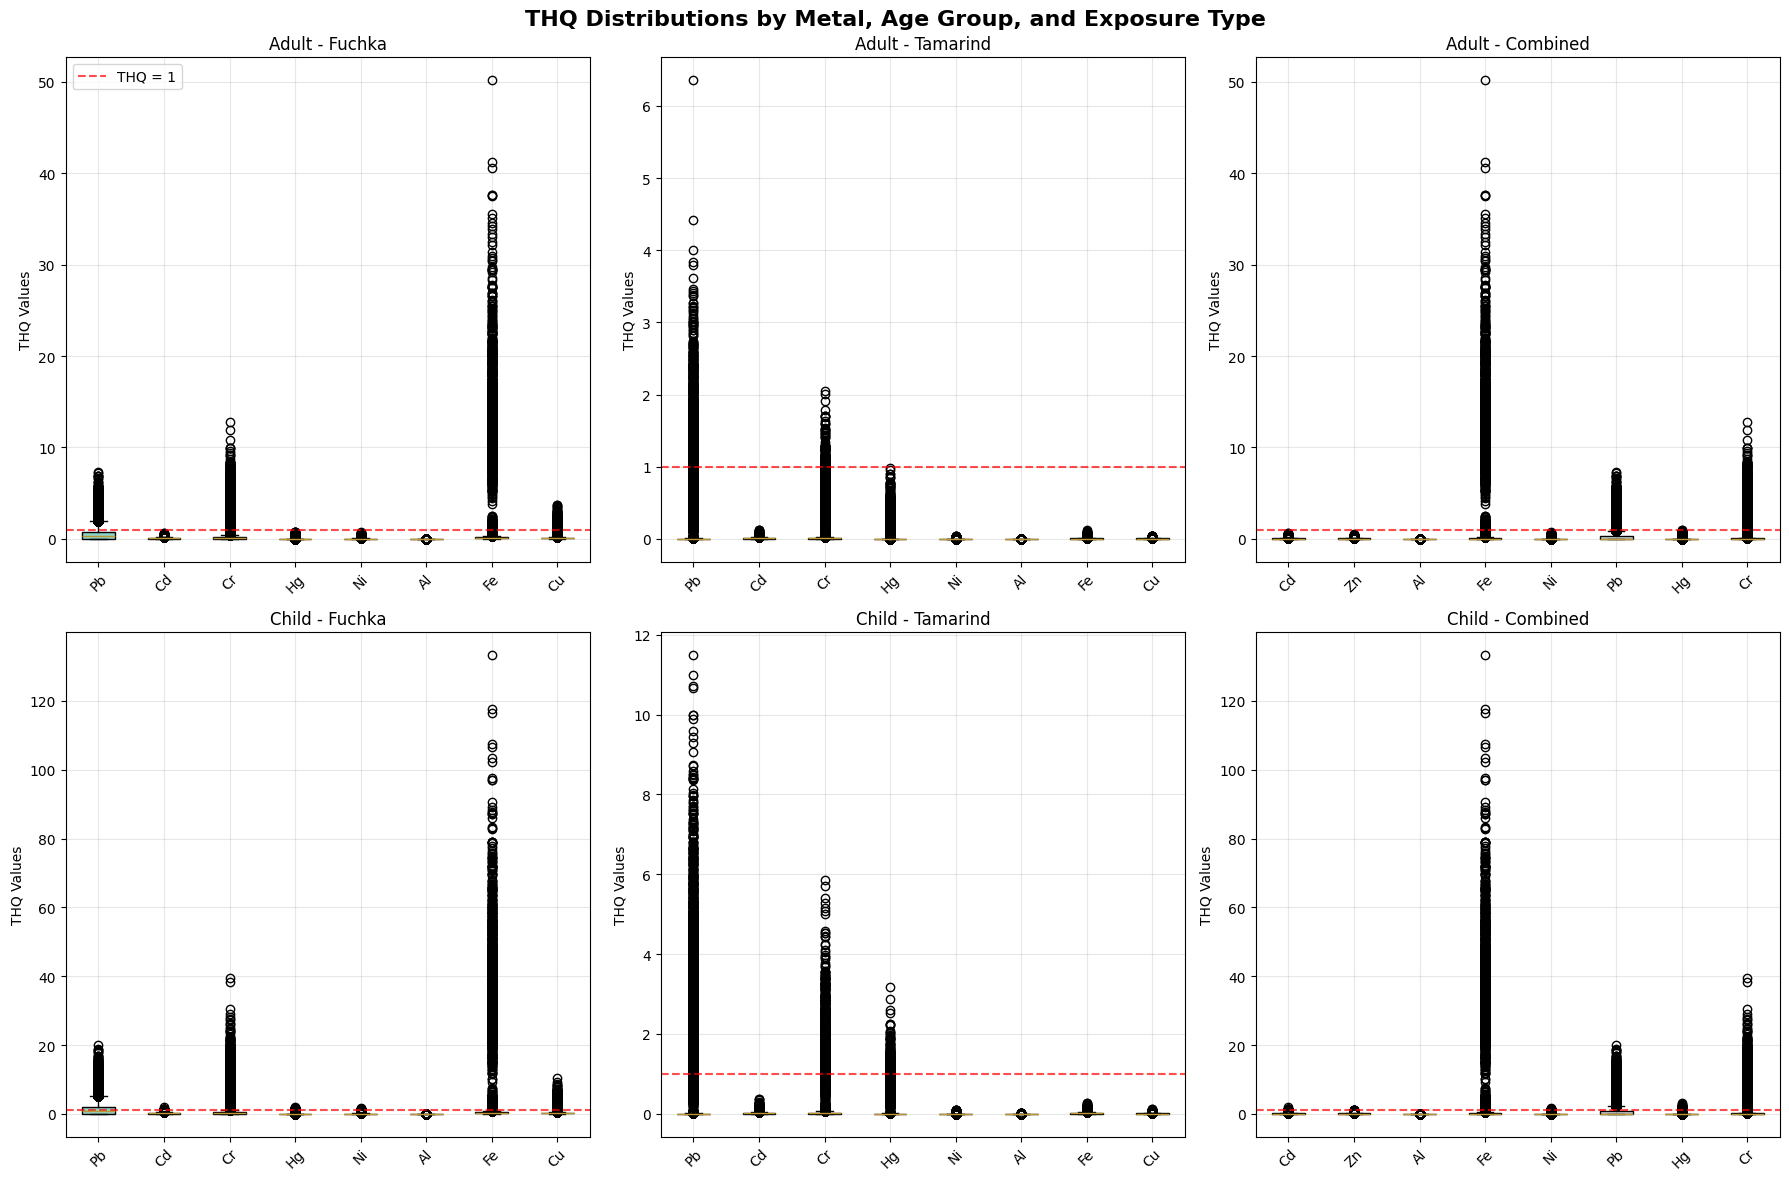

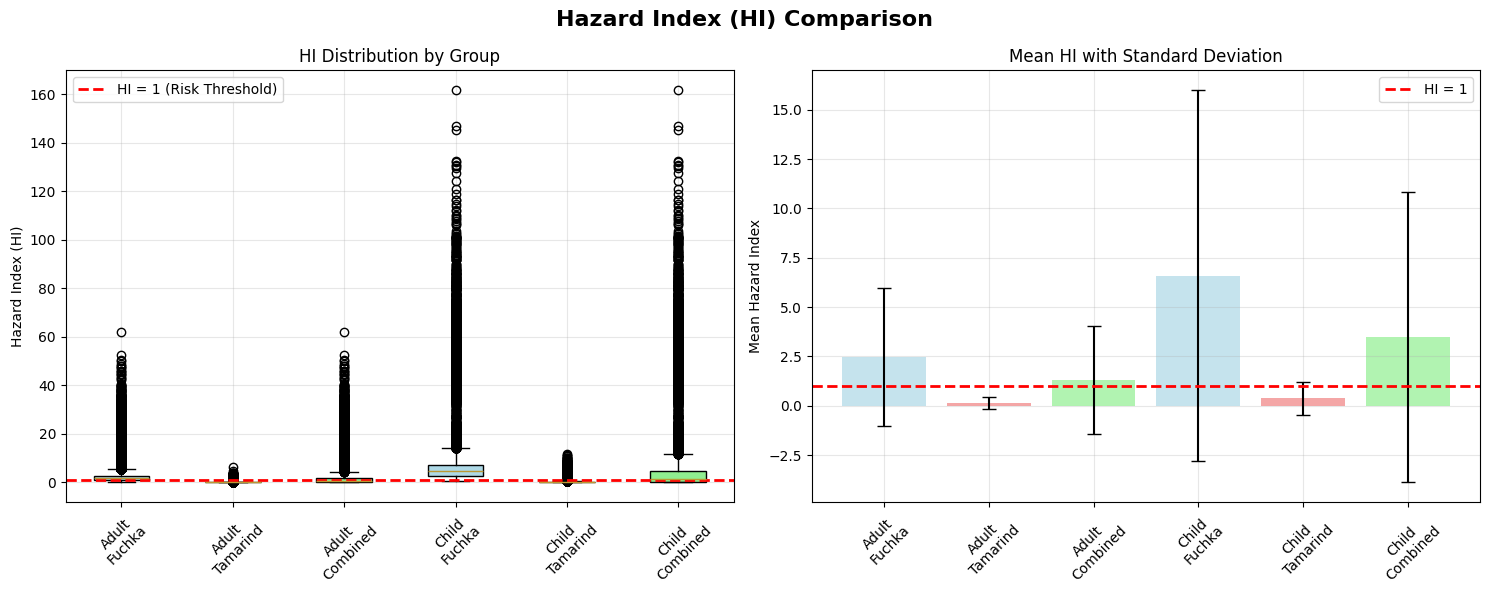

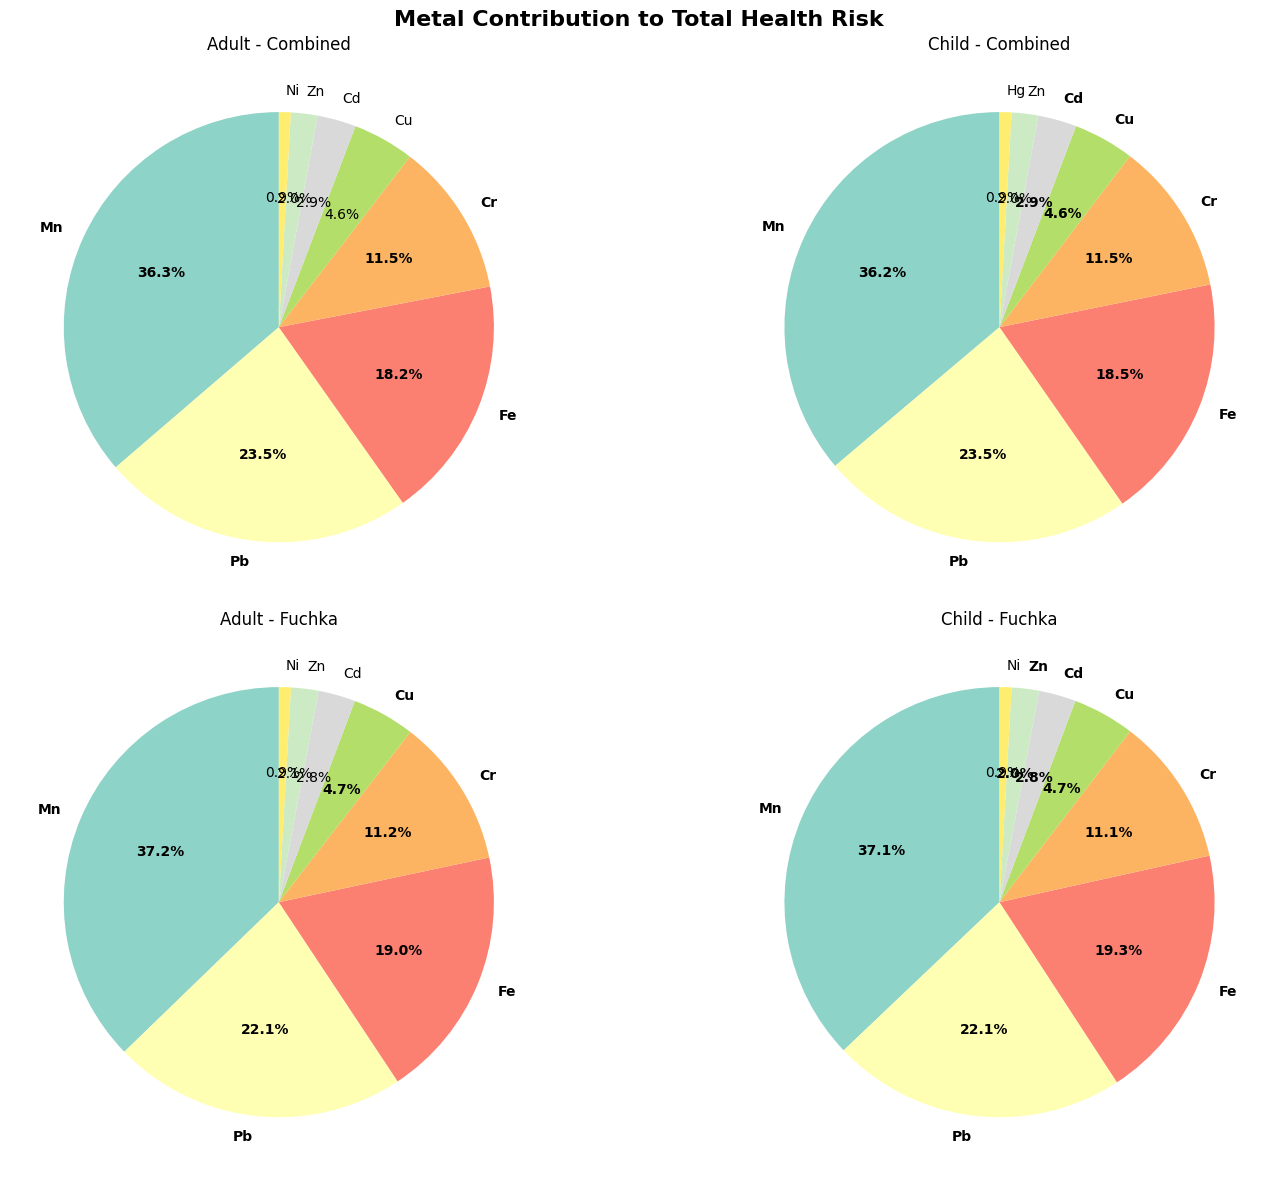

✅ All visualizations created and saved!


In [33]:
create_comprehensive_visualizations()

In [34]:
def export_results_to_excel(filename='Monte_Carlo_Health_Risk_Assessment_Results.xlsx'):
    """
    Export all results to a comprehensive Excel file
    """
    print(f"\n💾 Exporting results to {filename}...")
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        
        # Export the 6 main statistical tables
        for age_group in ['adult', 'child']:
            for exposure_type in ['fuchka', 'tamarind', 'combined']:
                sheet_name = f'{age_group.title()}_{exposure_type.title()}'
                table = statistical_tables[age_group][exposure_type]
                table.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Export sample-wise HI analysis
        for age_group in ['adult', 'child']:
            for exposure_type in ['fuchka', 'tamarind']:
                sheet_name = f'Samples_HI_{age_group.title()}_{exposure_type.title()}'
                sample_df = sample_hi_analysis[age_group][exposure_type]
                sample_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Export HI summary statistics
        hi_summary_data = []
        for age_group in ['adult', 'child']:
            for exposure_type in ['fuchka', 'tamarind', 'combined']:
                if exposure_type in hi_analysis[age_group]:
                    stats = hi_analysis[age_group][exposure_type]
                    hi_summary_data.append({
                        'Age_Group': age_group.title(),
                        'Exposure_Type': exposure_type.title(),
                        'Mean_HI': stats['mean'],
                        'Median_HI': stats['median'],
                        'SD_HI': stats['std'],
                        'P5_HI': stats['p5'],
                        'P95_HI': stats['p95'],
                        'Max_HI': stats['max'],
                        'Iterations_Over_1': stats['samples_over_1'],
                        'Percent_Over_1': stats['percent_over_1']
                    })
        
        hi_summary_df = pd.DataFrame(hi_summary_data)
        hi_summary_df.to_excel(writer, sheet_name='HI_Summary_Statistics', index=False)
        
        # Export input parameters and RfD values for reference
        params_df = pd.DataFrame([
            {'Parameter': key, 'Value': value, 'Unit': 'Various'} 
            for key, value in PARAMETERS.items()
        ])
        params_df.to_excel(writer, sheet_name='Input_Parameters', index=False)
        
        rfd_df = pd.DataFrame([
            {'Metal': metal, 'RfD': rfd, 'Unit': 'µg/kg/day'} 
            for metal, rfd in RFD_VALUES.items()
        ])
        rfd_df.to_excel(writer, sheet_name='RfD_Values', index=False)
        
        # Export sample concentration data
        fuchka_df.to_excel(writer, sheet_name='Fuchka_Concentrations', index=False)
        tamarind_df.to_excel(writer, sheet_name='Tamarind_Concentrations', index=False)
        
    print(f"✅ Results exported successfully to {filename}")
    print(f"📊 Excel file contains {12 + len(['HI_Summary_Statistics', 'Input_Parameters', 'RfD_Values', 'Fuchka_Concentrations', 'Tamarind_Concentrations'])} sheets")

In [35]:
export_results_to_excel()


💾 Exporting results to Monte_Carlo_Health_Risk_Assessment_Results.xlsx...
✅ Results exported successfully to Monte_Carlo_Health_Risk_Assessment_Results.xlsx
📊 Excel file contains 17 sheets


In [36]:
def generate_final_risk_assessment():
    """
    Generate final risk assessment conclusion
    """
    print(f"\n{'='*80}")
    print("🎯 FINAL RISK ASSESSMENT SUMMARY")
    print(f"{'='*80}")
    
    print(f"\n📋 STUDY PARAMETERS:")
    print(f"   Monte Carlo Iterations: {N_ITERATIONS:,}")
    print(f"   Number of Samples: {N_SAMPLES} (Fuchka) + {N_SAMPLES} (Tamarind)")
    print(f"   Metals Analyzed: {len(RFD_VALUES)}")
    print(f"   Age Groups: Adult, Child")
    print(f"   Total Simulations: {N_SAMPLES * 2 * 2 * N_ITERATIONS:,}")
    
    print(f"\n🔍 KEY FINDINGS:")
    
    # Overall risk assessment
    critical_findings = []
    
    for age_group in ['adult', 'child']:
        combined_hi = hi_analysis[age_group]['combined']
        
        print(f"\n  🔸 {age_group.upper()} POPULATION:")
        print(f"     Combined Exposure Mean HI: {combined_hi['mean']:.6f}")
        print(f"     Combined Exposure 95th Percentile HI: {combined_hi['p95']:.6f}")
        
        if combined_hi['mean'] >= 1.0:
            risk_status = "HIGH RISK - Immediate attention required"
            critical_findings.append(f"{age_group.title()} population shows high risk")
        elif combined_hi['p95'] >= 1.0:
            risk_status = "MODERATE RISK - Monitor closely"
            critical_findings.append(f"{age_group.title()} population shows moderate risk")
        else:
            risk_status = "ACCEPTABLE RISK - Within safe limits"
        
        print(f"     Risk Assessment: {risk_status}")
        
        # Identify highest risk metals
        combined_table = statistical_tables[age_group]['combined']
        high_risk_metals = combined_table[combined_table['Mean'] > 0.1]['Metal'].tolist()
        if high_risk_metals:
            print(f"     High Contributing Metals: {', '.join(high_risk_metals[:5])}")
    
    print(f"\n⚠️  CRITICAL FINDINGS:")
    if critical_findings:
        for finding in critical_findings:
            print(f"   - {finding}")
    else:
        print(f"   - All populations show acceptable risk levels")
    
    print(f"\n📊 EXPOSURE SOURCE COMPARISON:")
    for age_group in ['adult', 'child']:
        fuchka_hi = hi_analysis[age_group]['fuchka']['mean']
        tamarind_hi = hi_analysis[age_group]['tamarind']['mean']
        
        if fuchka_hi > tamarind_hi:
            primary_source = "Fuchka"
            ratio = fuchka_hi / tamarind_hi if tamarind_hi > 0 else float('inf')
        else:
            primary_source = "Tamarind"
            ratio = tamarind_hi / fuchka_hi if fuchka_hi > 0 else float('inf')
        
        print(f"   {age_group.title()}: {primary_source} is primary risk source (ratio: {ratio:.2f})")
    
    print(f"\n🎯 RECOMMENDATIONS:")
    print(f"   1. Regular monitoring of metal concentrations in food products")
    print(f"   2. Focus on metals with highest contribution percentages")
    print(f"   3. Consider exposure reduction strategies for high-risk populations")
    print(f"   4. Implement quality control measures for food safety")
    
    print(f"\n📁 OUTPUT FILES GENERATED:")
    print(f"   ✅ Monte_Carlo_Health_Risk_Assessment_Results.xlsx (Comprehensive data)")
    print(f"   ✅ THQ_Distributions_by_Group.png (THQ visualizations)")
    print(f"   ✅ HI_Comprehensive_Comparison.png (HI comparisons)")
    print(f"   ✅ Metal_Contribution_Analysis.png (Contribution analysis)")
    
    print(f"\n🎉 MONTE CARLO HEALTH RISK ASSESSMENT COMPLETED SUCCESSFULLY!")
    print(f"{'='*80}")

In [37]:
generate_final_risk_assessment()


🎯 FINAL RISK ASSESSMENT SUMMARY

📋 STUDY PARAMETERS:
   Monte Carlo Iterations: 1,000
   Number of Samples: 42 (Fuchka) + 42 (Tamarind)
   Metals Analyzed: 11
   Age Groups: Adult, Child
   Total Simulations: 168,000

🔍 KEY FINDINGS:

  🔸 ADULT POPULATION:
     Combined Exposure Mean HI: 1.315065
     Combined Exposure 95th Percentile HI: 3.996059
     Risk Assessment: HIGH RISK - Immediate attention required
     High Contributing Metals: Mn, Pb, Fe, Cr

  🔸 CHILD POPULATION:
     Combined Exposure Mean HI: 3.487949
     Combined Exposure 95th Percentile HI: 10.566228
     Risk Assessment: HIGH RISK - Immediate attention required
     High Contributing Metals: Mn, Pb, Fe, Cr, Cu

⚠️  CRITICAL FINDINGS:
   - Adult population shows high risk
   - Child population shows high risk

📊 EXPOSURE SOURCE COMPARISON:
   Adult: Fuchka is primary risk source (ratio: 17.36)
   Child: Fuchka is primary risk source (ratio: 17.36)

🎯 RECOMMENDATIONS:
   1. Regular monitoring of metal concentrations 